In [1]:
%pylab inline
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LogisticRegression
import clustering as cl
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

In [3]:
X_with_columns = pd.read_pickle("pickle_files/X.pkl")
Z_with_columns = pd.read_pickle("pickle_files/Z.pkl")

columns_to_drop = []

X_with_columns.drop(columns_to_drop, axis = 1, inplace=True)
Z_with_columns.drop(columns_to_drop, axis = 1, inplace=True)

X = np.array(X_with_columns)
Y = np.array(pd.read_pickle("pickle_files/Y.pkl"))
Z = np.array(Z_with_columns)
df_next_games = pd.read_pickle("pickle_files/next_games.pkl")

In [4]:
Z_with_columns

Pre-Match PPG (Home)  Pre-Match PPG (Away)  attendance  home_ppg  \
1512              0.793333              0.396667         0.0  0.858369   
1513              0.603333              0.626667         0.0  0.613734   
1514              0.396667              0.293333         0.0  0.347639   
1515              0.353333              0.313333         0.0  0.291845   
1516              0.376667              0.666667         0.0  0.321888   
1517              0.293333              0.460000         0.0  0.214592   
1518              0.460000              0.563333         0.0  0.429185   
1519              0.436667              0.333333         0.0  0.399142   
1520              0.166667              0.500000         0.0  0.051502   

      away_ppg  average_goals_per_match_pre_match  btts_percentage_pre_match  \
1512  0.441048                           0.654545                       0.63   
1513  0.742358                           0.665455                       0.76   
1514  0.305677                           0.625455                       0.63   
1515  0.331878                           0.529091                       0.50   
1516  0.794760                           0.580000                       0.53   
1517  0.524017                           0.563636                       0.60   
1518  0.659389                           0.507273                       0.50   
1519  0.358079                           0.609091                       0.63   
1520  0.576419                           0.590909                       0.69   

      over_15_percentage_pre_match  over_25_percentage_pre_match  \
1512                          0.91                          0.72   
1513                          0.94                          0.72   
1514                          0.97                          0.75   
1515                          0.78                          0.50   
1516                          0.85                          0.69   
1517                          0.72                          0.66   
1518                          0.81                          0.53   
1519                          0.88                          0.78   
1520                          0.82                          0.66   

      over_35_percentage_pre_match  ...  H_result_1  H_result_2  A_result_1  \
1512                          0.50  ...         1.0         1.0         0.5   
1513                          0.56  ...         0.5         0.5         0.0   
1514                          0.38  ...         0.0         1.0         0.0   
1515                          0.35  ...         0.0         0.5         0.0   
1516                          0.47  ...         0.0         1.0         0.5   
1517                          0.47  ...         0.0         0.0         0.0   
1518                          0.25  ...         0.5         0.0         1.0   
1519                          0.41  ...         0.0         0.0         0.0   
1520                          0.41  ...         0.0         0.0         1.0   

      A_result_2  H_HTGDIFF_1  H_HTGDIFF_2  A_ATGDIFF_1  A_ATGDIFF_2  \
1512         0.5     0.500000     0.785714     0.571429     0.571429   
1513         0.0     0.428571     0.428571     0.642857     0.928571   
1514         1.0     0.285714     0.571429     0.642857     0.357143   
1515         1.0     0.357143     0.428571     0.642857     0.428571   
1516         0.0     0.214286     0.571429     0.571429     0.642857   
1517         0.0     0.357143     0.357143     0.857143     0.642857   
1518         0.0     0.428571     0.357143     0.357143     0.642857   
1519         0.0     0.357143     0.285714     0.785714     0.785714   
1520         1.0     0.142857     0.071429     0.500000     0.500000   

      H_AVGHTGDIFF_1  A_AVGATGDIFF_1  
1512         0.71875        0.483871  
1513         0.37500        0.806452  
1514         0.09375        0.258065  
1515         0.37500        0.516129  
1516         0.46875        0.709677  
1517         0.15625        0.709677 

In [5]:
Z[0]

array([0.79333333, 0.39666667, 0.        , 0.8583691 , 0.44104803,
       0.65454545, 0.63      , 0.91      , 0.72      , 0.5       ,
       0.34666667, 0.56      , 0.85      , 0.59238095, 0.376     ,
       0.00251497, 0.12058824, 0.02045908, 0.73154362, 0.15227273,
       0.38163265, 0.33714286, 0.7106383 , 0.56944444, 0.42      ,
       0.        , 0.        , 1.        , 0.        , 0.48      ,
       0.        , 0.20652174, 0.        , 1.        , 0.65625   ,
       0.51612903, 1.        , 1.        , 0.5       , 0.5       ,
       0.5       , 0.78571429, 0.57142857, 0.57142857, 0.71875   ,
       0.48387097])

In [6]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
kf.get_n_splits(X)

4

In [7]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [   0    3    6 ... 1491 1492 1493] TEST: [   1    2    4    5    9   14   18   19   22   27   29   31   34   39
   40   45   47   52   53   54   55   56   58   61   75   80   82   85
   89   92   96  107  108  113  114  122  124  140  141  142  148  152
  156  159  161  175  178  182  184  186  187  191  192  198  202  204
  211  215  218  219  220  223  224  227  231  233  241  247  253  254
  260  268  270  278  279  295  298  299  302  303  308  309  310  315
  317  319  322  326  330  333  342  347  353  354  360  361  362  364
  376  381  390  393  408  412  414  422  425  427  434  435  436  438
  440  442  443  446  458  465  467  471  473  477  481  482  483  494
  501  511  512  513  516  517  520  526  527  529  530  536  539  540
  548  549  554  558  563  567  568  574  575  579  580  581  587  590
  601  602  609  615  619  620  621  629  632  641  642  646  648  651
  654  655  656  657  667  670  674  678  681  682  688  693  695  704
  708  712  716  717  720  7

## XGBoost

In [8]:
XGB_model = xgb.XGBClassifier(silent=False, 
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      reg_lambda = .5,
                      max_depth=5, 
                      gamma=5,
                      seed=82)

In [9]:
X_train

array([[0.        , 0.        , 0.61662877, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.3687089 , ..., 0.        , 0.375     ,
        0.51612903],
       [0.        , 0.        , 0.60624347, ..., 0.        , 0.375     ,
        0.51612903],
       ...,
       [0.55666667, 0.31      , 0.        , ..., 0.42857143, 0.40625   ,
        0.4516129 ],
       [0.62333333, 0.24333333, 0.        , ..., 0.57142857, 0.375     ,
        0.41935484],
       [0.8       , 0.37666667, 0.        , ..., 0.57142857, 0.53125   ,
        0.4516129 ]])

In [10]:
y_train

array([1., 3., 1., ..., 3., 2., 1.])

In [11]:
eval_set = [(X_train, y_train), (X_test, y_test)]

XGB_model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

[12:28:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.37700	validation_0-mlogloss:1.09697	validation_1-merror:0.44504	validation_1-mlogloss:1.09730
[1]	validation_0-merror:0.31283	validation_0-mlogloss:1.09466	validation_1-merror:0.35389	validation_1-mlogloss:1.09516
[2]	validation_0-merror:0.28966	validation_0-mlogloss:1.09233	validation_1-merror:0.32976	validation_1-mlogloss:1.09312
[3]	validation_0-merror:0.29412	validation_0-mlogloss:1.09011	validation_1-merror:0.31904	validation_1-mlogloss:1.09119
[4]	validation_0-merror:0.30036	validation_0-mlogloss:1.08787	validation_1-merror:0.33780	validation_1-mlogloss:1.08920
[5]	validation_0-merror:0.29144	validation_0

[65]	validation_0-merror:0.29946	validation_0-mlogloss:0.97884	validation_1-merror:0.31099	validation_1-mlogloss:0.98791
[66]	validation_0-merror:0.29679	validation_0-mlogloss:0.97766	validation_1-merror:0.31635	validation_1-mlogloss:0.98683
[67]	validation_0-merror:0.29768	validation_0-mlogloss:0.97634	validation_1-merror:0.31635	validation_1-mlogloss:0.98562
[68]	validation_0-merror:0.29768	validation_0-mlogloss:0.97480	validation_1-merror:0.31635	validation_1-mlogloss:0.98434
[69]	validation_0-merror:0.29768	validation_0-mlogloss:0.97298	validation_1-merror:0.31635	validation_1-mlogloss:0.98265
[70]	validation_0-merror:0.29679	validation_0-mlogloss:0.97145	validation_1-merror:0.31635	validation_1-mlogloss:0.98130
[71]	validation_0-merror:0.29679	validation_0-mlogloss:0.96988	validation_1-merror:0.32172	validation_1-mlogloss:0.97985
[72]	validation_0-merror:0.29679	validation_0-mlogloss:0.96818	validation_1-merror:0.31904	validation_1-mlogloss:0.97822
[73]	validation_0-merror:0.29768

[133]	validation_0-merror:0.29234	validation_0-mlogloss:0.89531	validation_1-merror:0.31635	validation_1-mlogloss:0.91177
[134]	validation_0-merror:0.29144	validation_0-mlogloss:0.89414	validation_1-merror:0.31635	validation_1-mlogloss:0.91078
[135]	validation_0-merror:0.29234	validation_0-mlogloss:0.89324	validation_1-merror:0.31635	validation_1-mlogloss:0.90995
[136]	validation_0-merror:0.29234	validation_0-mlogloss:0.89221	validation_1-merror:0.31635	validation_1-mlogloss:0.90894
[137]	validation_0-merror:0.29234	validation_0-mlogloss:0.89131	validation_1-merror:0.31635	validation_1-mlogloss:0.90805
[138]	validation_0-merror:0.29234	validation_0-mlogloss:0.89023	validation_1-merror:0.31635	validation_1-mlogloss:0.90699
[139]	validation_0-merror:0.29323	validation_0-mlogloss:0.88897	validation_1-merror:0.31635	validation_1-mlogloss:0.90587
[140]	validation_0-merror:0.29144	validation_0-mlogloss:0.88782	validation_1-merror:0.31635	validation_1-mlogloss:0.90490
[141]	validation_0-merro

[201]	validation_0-merror:0.28788	validation_0-mlogloss:0.83594	validation_1-merror:0.31635	validation_1-mlogloss:0.85791
[202]	validation_0-merror:0.28788	validation_0-mlogloss:0.83502	validation_1-merror:0.31635	validation_1-mlogloss:0.85718
[203]	validation_0-merror:0.28877	validation_0-mlogloss:0.83422	validation_1-merror:0.31635	validation_1-mlogloss:0.85644
[204]	validation_0-merror:0.28877	validation_0-mlogloss:0.83361	validation_1-merror:0.32172	validation_1-mlogloss:0.85594
[205]	validation_0-merror:0.28877	validation_0-mlogloss:0.83274	validation_1-merror:0.31635	validation_1-mlogloss:0.85513
[206]	validation_0-merror:0.28788	validation_0-mlogloss:0.83196	validation_1-merror:0.31367	validation_1-mlogloss:0.85442
[207]	validation_0-merror:0.28699	validation_0-mlogloss:0.83107	validation_1-merror:0.31635	validation_1-mlogloss:0.85364
[208]	validation_0-merror:0.28788	validation_0-mlogloss:0.83042	validation_1-merror:0.31635	validation_1-mlogloss:0.85308
[209]	validation_0-merro

[269]	validation_0-merror:0.28520	validation_0-mlogloss:0.79049	validation_1-merror:0.31367	validation_1-mlogloss:0.81750
[270]	validation_0-merror:0.28520	validation_0-mlogloss:0.78975	validation_1-merror:0.31635	validation_1-mlogloss:0.81687
[271]	validation_0-merror:0.28520	validation_0-mlogloss:0.78930	validation_1-merror:0.31635	validation_1-mlogloss:0.81646
[272]	validation_0-merror:0.28610	validation_0-mlogloss:0.78885	validation_1-merror:0.31635	validation_1-mlogloss:0.81604
[273]	validation_0-merror:0.28610	validation_0-mlogloss:0.78821	validation_1-merror:0.31635	validation_1-mlogloss:0.81551
[274]	validation_0-merror:0.28610	validation_0-mlogloss:0.78754	validation_1-merror:0.31635	validation_1-mlogloss:0.81484
[275]	validation_0-merror:0.28610	validation_0-mlogloss:0.78700	validation_1-merror:0.31635	validation_1-mlogloss:0.81437
[276]	validation_0-merror:0.28610	validation_0-mlogloss:0.78630	validation_1-merror:0.31635	validation_1-mlogloss:0.81387
[277]	validation_0-merro

[337]	validation_0-merror:0.27986	validation_0-mlogloss:0.75626	validation_1-merror:0.31367	validation_1-mlogloss:0.78831
[338]	validation_0-merror:0.27986	validation_0-mlogloss:0.75599	validation_1-merror:0.31367	validation_1-mlogloss:0.78808
[339]	validation_0-merror:0.27986	validation_0-mlogloss:0.75563	validation_1-merror:0.31367	validation_1-mlogloss:0.78776
[340]	validation_0-merror:0.27986	validation_0-mlogloss:0.75500	validation_1-merror:0.31635	validation_1-mlogloss:0.78726
[341]	validation_0-merror:0.27897	validation_0-mlogloss:0.75442	validation_1-merror:0.31367	validation_1-mlogloss:0.78673
[342]	validation_0-merror:0.27986	validation_0-mlogloss:0.75407	validation_1-merror:0.31367	validation_1-mlogloss:0.78638
[343]	validation_0-merror:0.27986	validation_0-mlogloss:0.75369	validation_1-merror:0.31367	validation_1-mlogloss:0.78603
[344]	validation_0-merror:0.27986	validation_0-mlogloss:0.75334	validation_1-merror:0.31635	validation_1-mlogloss:0.78566
[345]	validation_0-merro

[405]	validation_0-merror:0.27808	validation_0-mlogloss:0.73025	validation_1-merror:0.31904	validation_1-mlogloss:0.76585
[406]	validation_0-merror:0.27808	validation_0-mlogloss:0.72992	validation_1-merror:0.31904	validation_1-mlogloss:0.76561
[407]	validation_0-merror:0.27808	validation_0-mlogloss:0.72973	validation_1-merror:0.31904	validation_1-mlogloss:0.76550
[408]	validation_0-merror:0.27808	validation_0-mlogloss:0.72952	validation_1-merror:0.31904	validation_1-mlogloss:0.76530
[409]	validation_0-merror:0.27718	validation_0-mlogloss:0.72912	validation_1-merror:0.31904	validation_1-mlogloss:0.76495
[410]	validation_0-merror:0.27718	validation_0-mlogloss:0.72891	validation_1-merror:0.31904	validation_1-mlogloss:0.76476
[411]	validation_0-merror:0.27629	validation_0-mlogloss:0.72851	validation_1-merror:0.31904	validation_1-mlogloss:0.76447
[412]	validation_0-merror:0.27629	validation_0-mlogloss:0.72812	validation_1-merror:0.31904	validation_1-mlogloss:0.76415
[413]	validation_0-merro

[473]	validation_0-merror:0.27094	validation_0-mlogloss:0.70868	validation_1-merror:0.31904	validation_1-mlogloss:0.74771
[474]	validation_0-merror:0.27094	validation_0-mlogloss:0.70840	validation_1-merror:0.31904	validation_1-mlogloss:0.74745
[475]	validation_0-merror:0.27094	validation_0-mlogloss:0.70808	validation_1-merror:0.31904	validation_1-mlogloss:0.74717
[476]	validation_0-merror:0.27094	validation_0-mlogloss:0.70780	validation_1-merror:0.31904	validation_1-mlogloss:0.74698
[477]	validation_0-merror:0.27094	validation_0-mlogloss:0.70767	validation_1-merror:0.31904	validation_1-mlogloss:0.74691
[478]	validation_0-merror:0.27094	validation_0-mlogloss:0.70740	validation_1-merror:0.31904	validation_1-mlogloss:0.74668
[479]	validation_0-merror:0.27094	validation_0-mlogloss:0.70713	validation_1-merror:0.31904	validation_1-mlogloss:0.74640
[480]	validation_0-merror:0.27094	validation_0-mlogloss:0.70683	validation_1-merror:0.31904	validation_1-mlogloss:0.74614
[481]	validation_0-merro

[541]	validation_0-merror:0.27005	validation_0-mlogloss:0.69275	validation_1-merror:0.31635	validation_1-mlogloss:0.73476
[542]	validation_0-merror:0.27005	validation_0-mlogloss:0.69246	validation_1-merror:0.31635	validation_1-mlogloss:0.73454
[543]	validation_0-merror:0.27005	validation_0-mlogloss:0.69218	validation_1-merror:0.31635	validation_1-mlogloss:0.73436
[544]	validation_0-merror:0.27005	validation_0-mlogloss:0.69184	validation_1-merror:0.31635	validation_1-mlogloss:0.73405
[545]	validation_0-merror:0.27005	validation_0-mlogloss:0.69167	validation_1-merror:0.31635	validation_1-mlogloss:0.73389
[546]	validation_0-merror:0.27005	validation_0-mlogloss:0.69152	validation_1-merror:0.31635	validation_1-mlogloss:0.73374
[547]	validation_0-merror:0.27005	validation_0-mlogloss:0.69128	validation_1-merror:0.31635	validation_1-mlogloss:0.73351
[548]	validation_0-merror:0.27005	validation_0-mlogloss:0.69120	validation_1-merror:0.31635	validation_1-mlogloss:0.73345
[549]	validation_0-merro

[609]	validation_0-merror:0.26827	validation_0-mlogloss:0.67906	validation_1-merror:0.31367	validation_1-mlogloss:0.72394
[610]	validation_0-merror:0.26827	validation_0-mlogloss:0.67885	validation_1-merror:0.31367	validation_1-mlogloss:0.72376
[611]	validation_0-merror:0.26827	validation_0-mlogloss:0.67867	validation_1-merror:0.31367	validation_1-mlogloss:0.72361
[612]	validation_0-merror:0.26827	validation_0-mlogloss:0.67844	validation_1-merror:0.31367	validation_1-mlogloss:0.72345
[613]	validation_0-merror:0.26738	validation_0-mlogloss:0.67822	validation_1-merror:0.31367	validation_1-mlogloss:0.72327
[614]	validation_0-merror:0.26738	validation_0-mlogloss:0.67800	validation_1-merror:0.31367	validation_1-mlogloss:0.72306
[615]	validation_0-merror:0.26738	validation_0-mlogloss:0.67783	validation_1-merror:0.31367	validation_1-mlogloss:0.72291
[616]	validation_0-merror:0.26738	validation_0-mlogloss:0.67773	validation_1-merror:0.31367	validation_1-mlogloss:0.72280
[617]	validation_0-merro

[677]	validation_0-merror:0.26916	validation_0-mlogloss:0.66832	validation_1-merror:0.31635	validation_1-mlogloss:0.71559
[678]	validation_0-merror:0.26827	validation_0-mlogloss:0.66819	validation_1-merror:0.31635	validation_1-mlogloss:0.71545
[679]	validation_0-merror:0.26738	validation_0-mlogloss:0.66813	validation_1-merror:0.31635	validation_1-mlogloss:0.71536
[680]	validation_0-merror:0.26738	validation_0-mlogloss:0.66809	validation_1-merror:0.31635	validation_1-mlogloss:0.71534
[681]	validation_0-merror:0.26738	validation_0-mlogloss:0.66795	validation_1-merror:0.31367	validation_1-mlogloss:0.71517
[682]	validation_0-merror:0.26738	validation_0-mlogloss:0.66755	validation_1-merror:0.31635	validation_1-mlogloss:0.71483
[683]	validation_0-merror:0.26738	validation_0-mlogloss:0.66730	validation_1-merror:0.31367	validation_1-mlogloss:0.71465
[684]	validation_0-merror:0.26738	validation_0-mlogloss:0.66707	validation_1-merror:0.31367	validation_1-mlogloss:0.71449
[685]	validation_0-merro

[745]	validation_0-merror:0.26292	validation_0-mlogloss:0.65922	validation_1-merror:0.31099	validation_1-mlogloss:0.70851
[746]	validation_0-merror:0.26292	validation_0-mlogloss:0.65916	validation_1-merror:0.31099	validation_1-mlogloss:0.70846
[747]	validation_0-merror:0.26292	validation_0-mlogloss:0.65901	validation_1-merror:0.31099	validation_1-mlogloss:0.70839
[748]	validation_0-merror:0.26292	validation_0-mlogloss:0.65896	validation_1-merror:0.31099	validation_1-mlogloss:0.70836
[749]	validation_0-merror:0.26203	validation_0-mlogloss:0.65891	validation_1-merror:0.31099	validation_1-mlogloss:0.70832
[750]	validation_0-merror:0.26203	validation_0-mlogloss:0.65877	validation_1-merror:0.31099	validation_1-mlogloss:0.70820
[751]	validation_0-merror:0.26203	validation_0-mlogloss:0.65875	validation_1-merror:0.31099	validation_1-mlogloss:0.70818
[752]	validation_0-merror:0.26203	validation_0-mlogloss:0.65869	validation_1-merror:0.31099	validation_1-mlogloss:0.70811
[753]	validation_0-merro

[813]	validation_0-merror:0.26114	validation_0-mlogloss:0.65225	validation_1-merror:0.30831	validation_1-mlogloss:0.70328
[814]	validation_0-merror:0.26114	validation_0-mlogloss:0.65204	validation_1-merror:0.31099	validation_1-mlogloss:0.70308
[815]	validation_0-merror:0.26025	validation_0-mlogloss:0.65190	validation_1-merror:0.31099	validation_1-mlogloss:0.70300
[816]	validation_0-merror:0.26114	validation_0-mlogloss:0.65176	validation_1-merror:0.31099	validation_1-mlogloss:0.70288
[817]	validation_0-merror:0.26114	validation_0-mlogloss:0.65165	validation_1-merror:0.31099	validation_1-mlogloss:0.70281
[818]	validation_0-merror:0.26114	validation_0-mlogloss:0.65159	validation_1-merror:0.31099	validation_1-mlogloss:0.70278
[819]	validation_0-merror:0.26025	validation_0-mlogloss:0.65152	validation_1-merror:0.31099	validation_1-mlogloss:0.70269
[820]	validation_0-merror:0.26114	validation_0-mlogloss:0.65134	validation_1-merror:0.31099	validation_1-mlogloss:0.70266
[821]	validation_0-merro

[881]	validation_0-merror:0.26025	validation_0-mlogloss:0.64542	validation_1-merror:0.31099	validation_1-mlogloss:0.69809
[882]	validation_0-merror:0.26025	validation_0-mlogloss:0.64530	validation_1-merror:0.31099	validation_1-mlogloss:0.69799
[883]	validation_0-merror:0.26025	validation_0-mlogloss:0.64523	validation_1-merror:0.31099	validation_1-mlogloss:0.69792
[884]	validation_0-merror:0.26025	validation_0-mlogloss:0.64515	validation_1-merror:0.31099	validation_1-mlogloss:0.69789
[885]	validation_0-merror:0.26025	validation_0-mlogloss:0.64507	validation_1-merror:0.31099	validation_1-mlogloss:0.69784
[886]	validation_0-merror:0.26025	validation_0-mlogloss:0.64507	validation_1-merror:0.31099	validation_1-mlogloss:0.69784
[887]	validation_0-merror:0.26025	validation_0-mlogloss:0.64501	validation_1-merror:0.31099	validation_1-mlogloss:0.69778
[888]	validation_0-merror:0.26025	validation_0-mlogloss:0.64490	validation_1-merror:0.31099	validation_1-mlogloss:0.69773
[889]	validation_0-merro

[949]	validation_0-merror:0.25668	validation_0-mlogloss:0.64004	validation_1-merror:0.31367	validation_1-mlogloss:0.69432
[950]	validation_0-merror:0.25668	validation_0-mlogloss:0.63986	validation_1-merror:0.31367	validation_1-mlogloss:0.69418
[951]	validation_0-merror:0.25579	validation_0-mlogloss:0.63979	validation_1-merror:0.31367	validation_1-mlogloss:0.69407
[952]	validation_0-merror:0.25579	validation_0-mlogloss:0.63963	validation_1-merror:0.31367	validation_1-mlogloss:0.69392
[953]	validation_0-merror:0.25579	validation_0-mlogloss:0.63948	validation_1-merror:0.31367	validation_1-mlogloss:0.69382
[954]	validation_0-merror:0.25579	validation_0-mlogloss:0.63940	validation_1-merror:0.31367	validation_1-mlogloss:0.69375
[955]	validation_0-merror:0.25579	validation_0-mlogloss:0.63934	validation_1-merror:0.31367	validation_1-mlogloss:0.69369
[956]	validation_0-merror:0.25668	validation_0-mlogloss:0.63926	validation_1-merror:0.31367	validation_1-mlogloss:0.69362
[957]	validation_0-merro

In [12]:
y_pred.shape

(373,)

In [13]:
pd.Series(y_pred).value_counts()

3.0    237
1.0    115
2.0     21
dtype: int64

## LogisticRegression

In [14]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)

In [15]:
pd.Series(LR_y_pred).value_counts()

3.0    211
1.0    116
2.0     46
dtype: int64

## Comparassion

In [16]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 74.51%
XGB Accuracy: 68.63%
LR train Accuracy: 75.31%
LR Accuracy: 72.39%


In [17]:
features_names = list(X_with_columns.columns)

In [18]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGHTGDIFF                          4.19%
Feature Importance: odds_ft_away_team_win               4.12%
Feature Importance: AVGATGDIFF                          4.05%
Feature Importance: odds_ft_home_team_win               3.79%
Feature Importance: awt_3                               3.49%
Feature Importance: odds_ft_over25                      3.37%
Feature Importance: odds_ft_draw                        3.04%
Feature Importance: away_ppg                            2.84%
Feature Importance: home_ppg                            2.79%
Feature Importance: A_AVGATGDIFF_1                      2.63%
Feature Importance: H_AVGHTGDIFF_1                      2.49%
Feature Importance: awt_1                               2.32%
Feature Importance: attendance                          2.22%
Feature Importance: ht_0                                2.21%
Feature Importance: ht_4                                2.11%
Feature Importance: H_HTGDIFF_1                         2.09%
Feature 

In [19]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['odds_ft_over35',
 'over_15_percentage_pre_match',
 'btts_percentage_pre_match',
 'odds_ft_over45',
 'ht_3']

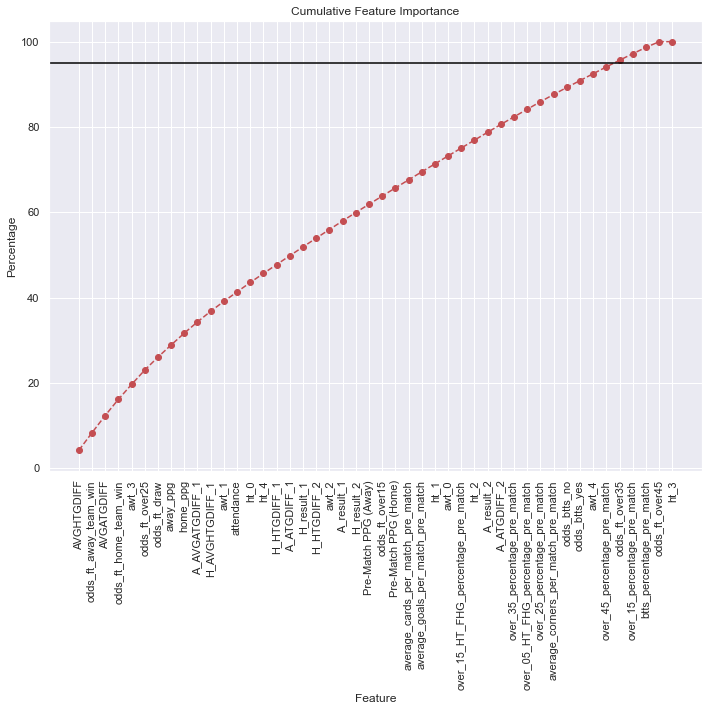

In [20]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

In [21]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes=classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             #rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.70642202 0.26605505 0.02752294]
 [0.05780347 0.93641618 0.00578035]
 [0.30769231 0.50549451 0.18681319]]


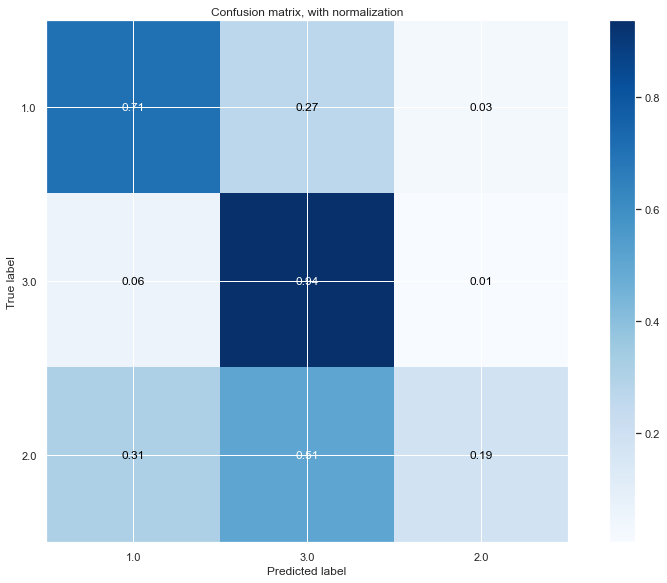

In [22]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=pd.Series(Y).unique(), labels=pd.Series(Y).unique(),
                      title='Confusion matrix, with normalization', normalize=True)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def learning_curve(preds,y_test, model):
    predictions = [round(value) for value in preds]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

Accuracy: 68.63%


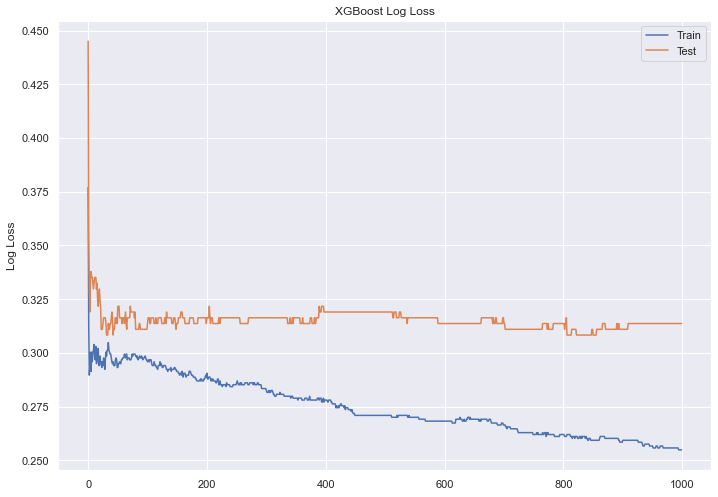

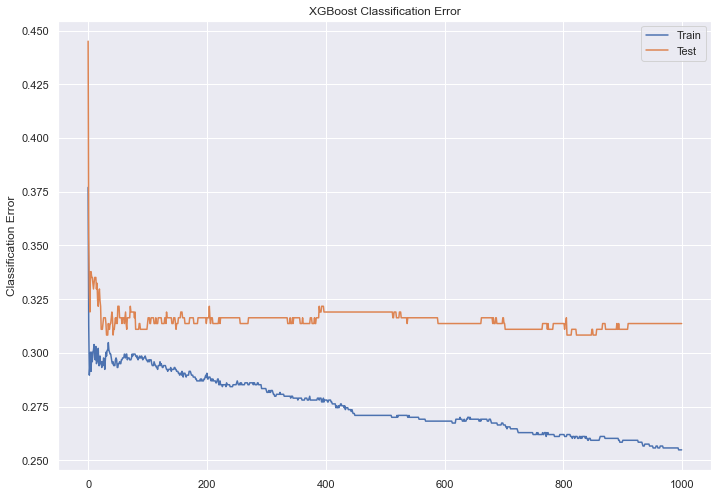

In [25]:
learning_curve(y_pred,y_test,XGB_model)

# TODO CHECK OVERFITTING

## GridSearch 

In [26]:
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from matplotlib import pyplot

# xgb = XGBClassifier(learning_rate=0.005, n_estimators=50, objective='multi:softprob',
#                     silent=True, nthread=1, reg_alpha = 0.2, reg_lambda = .5, gamma=5)

In [27]:
# params = {
#         'min_child_weight': [1, 5, 10,15],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5,6,7],
#         'n_estimators': [400, 800, 1000],
#         'early_stopping_rounds': [3,5,10]
#         }

In [28]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# folds = 4
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=5, cv=skf.split(X,Y), verbose=3, random_state=1001 )

In [29]:
# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [30]:
# from datetime import datetime

# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, Y)
# timer(start_time) 

In [31]:
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)

In [32]:
# best=random_search.best_params_

# xgb_best = XGBClassifier(
#     silent=False, 
#     objective='multi:softprob',
#     colsample_bytree = best['colsample_bytree'],
#     min_child_weight = best['min_child_weight'],
#     subsample = best['subsample'],
#     n_estimators=best['n_estimators'], 
#     max_depth=best['max_depth'], 
#     seed=82,
#     early_stopping_rounds=best['early_stopping_rounds']
# )


In [33]:
# eval_set = [(X_train, y_train), (X_test, y_test)]
# xgb_best.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
# y_pred3 = xgb_best.predict(X_test)
# y_pred_train = xgb_best.predict(X_train)
# accuracy = accuracy_score(y_test, y_pred3)
# accuracy_train = accuracy_score(y_train, y_pred_train)

In [34]:
# print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
# print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))

## Predict Result for Next Games

In [35]:
z_pred = XGB_model.predict(Z)

In [36]:
xgb_df_next_games = df_next_games.copy()

In [37]:
xgb_df_next_games['predicted_result'] = z_pred

In [38]:
xgb_df_next_games['tipico quota']=0
xgb_df_next_games['R']=False

In [39]:
lr_z_pred = LR.predict(Z)

In [40]:
lr_df_next_games = df_next_games.copy()

In [41]:
lr_df_next_games['predicted_result'] = lr_z_pred

In [42]:
import sqlite3
# Create your connection.
cnx1 = sqlite3.connect('data1.db')
cnx2 = sqlite3.connect('data2.db')

### Check Before Save in DB

In [43]:
xgb_df_next_games

home_team_name       away_team_name  predicted_result  tipico quota  \
1512      Bayern München             Freiburg               3.0             0   
1513          RB Leipzig    Borussia Dortmund               1.0             0   
1514          Hoffenheim         Union Berlin               3.0             0   
1515  Fortuna Düsseldorf             Augsburg               1.0             0   
1516          Hertha BSC     Bayer Leverkusen               1.0             0   
1517            Mainz 05        Werder Bremen               1.0             0   
1518          Schalke 04            Wolfsburg               1.0             0   
1519                Köln  Eintracht Frankfurt               1.0             0   
1520           Paderborn  Borussia M'gladbach               1.0             0   

          R  
1512  False  
1513  False  
1514  False  
1515  False  
1516  False  
1517  False  
1518  False  
1519  False  
1520  False

In [44]:
lr_df_next_games

home_team_name       away_team_name  predicted_result
1512      Bayern München             Freiburg               2.0
1513          RB Leipzig    Borussia Dortmund               1.0
1514          Hoffenheim         Union Berlin               3.0
1515  Fortuna Düsseldorf             Augsburg               1.0
1516          Hertha BSC     Bayer Leverkusen               1.0
1517            Mainz 05        Werder Bremen               1.0
1518          Schalke 04            Wolfsburg               1.0
1519                Köln  Eintracht Frankfurt               1.0
1520           Paderborn  Borussia M'gladbach               1.0

In [45]:
# xgb_df_next_games.to_sql(name='xgb_df_next_games', con=cnx1,if_exists='append')
# lr_df_next_games.to_sql(name='lr_df_next_games', con=cnx2,if_exists='append')

# Access SQLite DB

### Delete

In [ ]:
# def deleteRecord():
#     try:
#         sqliteConnection = sqlite3.connect('data1.db')
#         cursor = sqliteConnection.cursor()
#         print("Connected to SQLite")

#         # Deleting single record now
#         sql_delete_query = """DELETE from xgb_df_next_games where rowid > 9"""
#         cursor.execute(sql_delete_query)
#         sqliteConnection.commit()
#         print("Record deleted successfully ")
#         cursor.close()

#     except sqlite3.Error as error:
#         print("Failed to delete record from sqlite table", error)
#     finally:
#         if (sqliteConnection):
#             sqliteConnection.close()
#             print("the sqlite connection is closed")

# deleteRecord()

### Read

In [46]:
df_xgb = pd.read_sql_query("SELECT * from xgb_df_next_games", cnx1)
df_lr = pd.read_sql_query("SELECT * from lr_df_next_games", cnx2)